# Movie Topic Model and Recommendation Model

**Author**: XueMei Jin, Sanhe Hu

**IMPORTANT, use** ``conda_pytorch_p36`` **for Notebook Kernel**.

<img src="https://m.media-amazon.com/images/M/MV5BM2MyNjYxNmUtYTAwNi00MTYxLWJmNWYtYzZlODY3ZTk3OTFlXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SY1000_CR0,0,704,1000_AL_.jpg" alt="God Father" style="width: 200px;"/>

**About the Data Set**

The training data set includes 16,700 movie records that are released between 2009 to 2019, 
https://github.com/sidooms/MovieTweetings/blob/master/latest/movies.dat
- https://developers.themoviedb.org/3/movies/get-movie-details

**Movie Keyword Model**:

We use scikit-learn TF-IDF to extract important keywords from a movie plot to characteriorze in the collected texts. These keywords cab be used as a very simple summaries or topics for the text selected from the movie episode, which can also be one of the sources in the following content-based movie recommendation engine. 

**Movie Recommendation Model**:

Our movie recommendation system is a machine learning content-based engine since we make predictions based on the specific contents in the movie plot and not based on the user. We used contens of genres, title, overview and taglines in the movie plot to recommend 10 similia movies. In order to enhance and provide more accurate similia movies, we added some statistic analysis on 'vote_average' and 'vote_cont' in moview data set. We calculate average of vote, filter out all qualified movies, and compute the weighted rating of each movie.


## 1. Install Machine Learning Python Librarys
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
This project primarily

In [30]:
import os

if os.environ.get("PWD") == "/home/ec2-user":
    !pip install boto3
    !pip install pathlib_mate==0.0.15
    !pip install numpy==1.17.0
    !pip install pandas==0.23.4
    !pip install scikit-learn==0.21.3
    !pip install nltk==3.4.4
    !pip install stop_words==2018.7.23
    !pip install wordcloud==1.5.1
    !pip install matplotlib==3.1.1
else:
    %pip install boto3
    %pip install pathlib_mate==0.0.15
    %pip install numpy==1.17.0
    %pip install pandas==0.23.4
    %pip install scikit-learn==0.21.3
    %pip install nltk==3.4.4
    %pip install stop_words==2018.7.23
    %pip install wordcloud==1.5.1
    %pip install matplotlib==3.1.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 163kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 7.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Download Dataset

The training dataset data we use here is the processed, cleaned, aggregated, deduplicated data. After the first time you deployed the solution, it takes about 30 minutes to crawl all the data. After that, it takes aboutt 30 minutes to aggregate and merge data from multiple data source.

**To avoid waiting too long to run the machine learning model, we made the training dataset public on S3 bucket, so we can quickly download it and start**.

In [9]:
from pathlib_mate import PathCls as Path
training_dataset_path = Path(Path.home(), "dossier_data_with_recommends.json")

In [44]:
if not training_dataset_path.exists():
    !aws s3 cp \
        s3://rdso-lab-rdso-lbd-svcs-prod/02-processed/aggregated-dossier-data/dossier_data_with_recommends.json \
        ${HOME}/dossier_data_with_recommends.json

download: s3://rdso-lab-rdso-lbd-svcs-prod/02-processed/aggregated-dossier-data/dossier_data_with_recommends.json to ../../../dossier_data_with_recommends.json


In [7]:
import json
import numpy as np
import pandas as pd
from pathlib_mate import PathCls as Path

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
nltk.download("stopwords")
from stop_words import get_stop_words


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanhehu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# load data into memory this block takes 5-10 seconds.
dossier_data_list = json.loads(training_dataset_path.read_text(encoding="utf-8"))

In [16]:
# Load movie title and plot.
# in www.themoviedb.org data set, the `movie_title` field is movie title, the `plot_summary` field is movie plot
df_idf = list()
for dossier_data in dossier_data_list:
    try:
        imdb_id = dossier_data["root_id"]
        the_movie_db_id = dossier_data["movie_id"]
        title = dossier_data["movie_title"]
        overview = dossier_data["movieSummaries"][0]["plot_summary"]
        tagline = dossier_data.get("tagline", "")
        genres = ", ".join([dct["genre"] for dct in dossier_data.get("movieGenres", [])])
        vote_average = dossier_data["vote_average"]
        vote_count = dossier_data["vote_count"]
        df_idf.append((
            imdb_id, 
            the_movie_db_id,
            title, 
            overview, 
            tagline, 
            genres, 
            vote_average,
            vote_count,
        ))
    except:
        pass
df_idf = pd.DataFrame(
    df_idf, 
    columns=[
        "imdb_id", "the_movie_db_id", "title", "overview", "tagline", "genres", 
        "vote_average", "vote_count", 
    ]
)
df_idf.index = df_idf["imdb_id"] # used to access row by imdb_id
df_idf["text"] = df_idf["title"] + df_idf["overview"]
df_idf.head(3)

,imdb_id,the_movie_db_id,title,overview,tagline,genres,vote_average,vote_count,text
imdb_id,,,,,,,,,
tt5027162,tt5027162,476791,Aurora Borealis - Northern Light,The Aurora Borealis is a story of family that ...,,Drama,6.1,5.0,Aurora Borealis - Northern LightThe Aurora Bor...
tt1556190,tt1556190,72721,Nostalgia for the Light,"In Chile's Atacama Desert, astronomers peer de...",,Documentary,7.8,59.0,Nostalgia for the LightIn Chile's Atacama Dese...
tt3859310,tt3859310,341689,How to Talk to Girls at Parties,"Croydon, 1977. A trio of punk teenagers goes t...",Some girls are out of this world,"Comedy, Music, Romance, Science Fiction",6.4,168.0,"How to Talk to Girls at PartiesCroydon, 1977. ..."


In [22]:
# Load english stop words
stopwords = get_stop_words("en")
cv = CountVectorizer(max_df=0.85, stop_words=stopwords, max_features=1000)
word_count_vector = cv.fit_transform(df_idf['text'].apply(lambda x: np.str_(x)))

# Define TF-IDF transformer
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

/Users/sanhehu/venvs/python/3.6.2/rdso_ml_venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [21]:
def sort_coo_matrix(coo_matrix):
    """
    :type coo_matrix: scipy.sparse.coo.coo_matrix
    
    :rtype: List[Tuple[int, float]]
    :return: List[Tuple[word_index, weight]]
    """
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return list(sorted(tuples, key=lambda x: x[1], reverse=True))


def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """
    get the feature names and tf-idf score of top n items
    
    :type feature_names: List[str]
    :type sorted_items: List[Tuple[int, float]]
    
    :rtype: Dict[str, float]
    :return: Dict[keyword, weight]
    """
    # use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    # create a tuples of feature,score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


feature_names = cv.get_feature_names()

keyword_list = list()
for text in df_idf["text"]:
    try:
        tf_idf_vector = tfidf_transformer.transform(cv.transform([text, ]))
        sorted_items = sort_coo_matrix(tf_idf_vector.tocoo()) 
        keywords = extract_topn_from_vector(feature_names, sorted_items, 5)
        keyword = json.dumps(keywords)
        keyword_list.append(keyword)
    except:
        keyword_list.append(None)
df_idf["keyword"] = keyword_list
df_idf.head(10)

,imdb_id,the_movie_db_id,title,overview,tagline,genres,vote_average,vote_count,text,keyword
imdb_id,,,,,,,,,,
tt5027162,tt5027162,476791,Aurora Borealis - Northern Light,The Aurora Borealis is a story of family that ...,,Drama,6.1,5.0,Aurora Borealis - Northern LightThe Aurora Bor...,"{""mother"": 0.324, ""back"": 0.317, ""lawyer"": 0.2..."
tt1556190,tt1556190,72721,Nostalgia for the Light,"In Chile's Atacama Desert, astronomers peer de...",,Documentary,7.8,59.0,Nostalgia for the LightIn Chile's Atacama Dese...,"{""desert"": 0.463, ""deep"": 0.419, ""body"": 0.418..."
tt3859310,tt3859310,341689,How to Talk to Girls at Parties,"Croydon, 1977. A trio of punk teenagers goes t...",Some girls are out of this world,"Comedy, Music, Romance, Science Fiction",6.4,168.0,"How to Talk to Girls at PartiesCroydon, 1977. ...","{""girls"": 0.751, ""punk"": 0.316, ""teenagers"": 0..."
tt9759978,tt9759978,560527,The Dude in Me,A movie about a teenager who falls from the ro...,A body swap that changed everything,"Fantasy, Comedy",7.9,8.0,The Dude in MeA movie about a teenager who fal...,"{""gangster"": 0.495, ""teenager"": 0.449, ""body"":..."
tt5662106,tt5662106,394269,Lemonade,"The second ""visual album"" (a collection of sho...",,Music,8.7,86.0,"LemonadeThe second ""visual album"" (a collectio...","{""films"": 0.456, ""short"": 0.43, ""second"": 0.42..."
tt3416532,tt3416532,258230,A Monster Calls,A boy imagines a monster that helps him deal w...,Stories are wild creatures.,"Drama, Fantasy",7.1,1964.0,A Monster CallsA boy imagines a monster that h...,"{""monster"": 0.663, ""helps"": 0.319, ""difficult""..."
tt2404738,tt2404738,179538,Witching & Bitching,"In this heist film turned horror fest, directo...",,"Comedy, Horror",6.3,319.0,Witching & BitchingIn this heist film turned h...,"{""ancient"": 0.341, ""la"": 0.34, ""need"": 0.335, ..."
tt5827360,tt5827360,461957,Catching Feelings,"Set in a chic and middle class Johannesburg, a...",,"Romance, Comedy, Drama",5.7,6.0,Catching FeelingsSet in a chic and middle clas...,"{""unexpectedly"": 0.333, ""upside"": 0.331, ""jour..."
tt3837196,tt3837196,267573,Man on High Heels,Ji-wook is a cold-blooded detective who would ...,I killed her in me,Action,7.0,42.0,Man on High HeelsJi-wook is a cold-blooded det...,"{""however"": 0.303, ""woman"": 0.24, ""criminals"":..."


## Movie Keyword Extraction Demo

Now we have extracted the significant keywords from the title and plots, a new column ``keyword`` is created to store the results.

You can put random imdb id (includes the ``tt``) and its name into the ``movie_id_mapper`` dictionary, in the next block. The code should returns the keywords of that movie, so you can see if does make sence.

In [25]:
movie_id_mapper = {
    "tt1853728": "Django Unchained",
    "tt2404738": "Witching & Bitching",
} # type: Dict[str, str], Dict[imdb_id, movie_title]

sub_df = df_idf.loc[list(movie_id_mapper), ["keyword",]]
for ind, row in sub_df.iterrows():
    movie_title = movie_id_mapper[ind]
    print(movie_title, row["keyword"])

Django Unchained {"hunter": 0.41, "german": 0.384, "brutal": 0.377, "rescue": 0.374, "owner": 0.373}
Witching & Bitching {"ancient": 0.341, "la": 0.34, "need": 0.335, "de": 0.324, "horror": 0.321}


## Feature Engineering for Movie Recommendation Model


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

df_idf["text_new"] = df_idf["genres"].astype(str) + "_" \
    + df_idf["genres"].astype(str) + "_" \
    + df_idf["genres"].astype(str) + "_" \
    + df_idf["title"].astype(str) + "_" \
    + df_idf["title"].astype(str) + "_" \
    + df_idf["overview"].astype(str) + "_" \
    + df_idf["overview"].astype(str) + "_" \
    + df_idf["tagline"].astype(str) + "_" \
    + df_idf["tagline"].astype(str)
df_idf["text_new"].head(3)

imdb_id
tt5027162    Drama_Drama_Drama_Aurora Borealis - Northern L...
tt1556190    Documentary_Documentary_Documentary_Nostalgia ...
tt3859310    Comedy, Music, Romance, Science Fiction_Comedy...
Name: text_new, dtype: object

In [27]:
# Calculate average of vote
C = df_idf["vote_average"].mean()

# Calculate the minimum number of votes
m = df_idf["vote_count"].quantile(0.90)

# Filter out all qualified movies into a new dataframe
q_movies = df_idf.copy().loc[df_idf["vote_count"] >= m]

# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x["vote_count"]
    R = x["vote_average"]
    return (v/(v+m) * R) + (m/(m+v) * C)

# Define a new feature 'score' and calculate its value with weighted_rating()`
q_movies["score"] = q_movies.apply(weighted_rating, axis=1)

# Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

# Display the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
imdb_id,,,,
tt5311514,Your Name.,4374.0,8.6,8.316560
tt4154796,Avengers: Endgame,8667.0,8.4,8.260244
tt2582802,Whiplash,8132.0,8.4,8.251588
tt1375666,Inception,22772.0,8.3,8.247101
tt4154756,Avengers: Infinity War,14822.0,8.3,8.219664
tt4633694,Spider-Man: Into the Spider-Verse,4743.0,8.4,8.155766
tt0816692,Interstellar,19150.0,8.2,8.139927
tt1675434,The Intouchables,10206.0,8.2,8.089770
tt5726616,Call Me by Your Name,5235.0,8.3,8.085510


In [28]:
# Define a TF-IDF Vectorizer Object and remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words="english")

# Replace NaN with an empty string
df_idf["text_new"] = df_idf["text_new"].fillna("")
df_idf.drop_duplicates("title", inplace=True)
df_idf.drop_duplicates("the_movie_db_id", inplace=True)

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_idf["text_new"])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

df_idf.head(3)

,imdb_id,the_movie_db_id,title,overview,tagline,genres,vote_average,vote_count,text,keyword,text_new
imdb_id,,,,,,,,,,,
tt5027162,tt5027162,476791,Aurora Borealis - Northern Light,The Aurora Borealis is a story of family that ...,,Drama,6.1,5.0,Aurora Borealis - Northern LightThe Aurora Bor...,"{""mother"": 0.324, ""back"": 0.317, ""lawyer"": 0.2...",Drama_Drama_Drama_Aurora Borealis - Northern L...
tt1556190,tt1556190,72721,Nostalgia for the Light,"In Chile's Atacama Desert, astronomers peer de...",,Documentary,7.8,59.0,Nostalgia for the LightIn Chile's Atacama Dese...,"{""desert"": 0.463, ""deep"": 0.419, ""body"": 0.418...",Documentary_Documentary_Documentary_Nostalgia ...
tt3859310,tt3859310,341689,How to Talk to Girls at Parties,"Croydon, 1977. A trio of punk teenagers goes t...",Some girls are out of this world,"Comedy, Music, Romance, Science Fiction",6.4,168.0,"How to Talk to Girls at PartiesCroydon, 1977. ...","{""girls"": 0.751, ""punk"": 0.316, ""teenagers"": 0...","Comedy, Music, Romance, Science Fiction_Comedy..."


We use Cosine similarity to compute cosine distance.

The similarity will be equal to 1 if the two vectors are identical, and it will be 0 if the two are orthogonal. In other words, the similarity is a number bounded between 0 and 1 that tells us how much the two vectors are similar.

Run the recommendation model to generate recommend movie for all 17,000 records.

In [29]:
# Function that takes in movie title as input and outputs most similar movies

# the_movie_db_id -> df_idf DataFrame row number (0 ~ N) mapper
the_movie_db_id_to_df_row_number_mapper = {
    the_movie_db_id: row_num
    for row_num, the_movie_db_id in enumerate(df_idf["the_movie_db_id"])
}
imdb_id_to_the_movie_db_id = {
    imdb_id: the_movie_db_id
    for imdb_id, the_movie_db_id in zip(df_idf.index, df_idf["the_movie_db_id"])
}

def get_recommendations(the_movie_db_id, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    df_row_num = the_movie_db_id_to_df_row_number_mapper[the_movie_db_id]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[df_row_num]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    return movie_indices


# populate recommendation movies
import json

similar_movies_list = list()
for index, row in df_idf.iterrows():
    the_movie_db_id = row["the_movie_db_id"]
    movie_indices = get_recommendations(the_movie_db_id)
    sub_df = df_idf.loc[df_idf.index[movie_indices], ["the_movie_db_id", "title", "poster_path"]]
    json_text = sub_df.to_json(orient="records")
    similar_movies_list.append(json_text)
    
df_idf["similar_movies"] = similar_movies_list
df_idf[["title", "similar_movies"]].head(5)

/Users/sanhehu/venvs/python/3.6.2/rdso_ml_venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


,title,similar_movies
imdb_id,,
tt5027162,Aurora Borealis - Northern Light,"[{""the_movie_db_id"":""405473"",""title"":""A Date f..."
tt1556190,Nostalgia for the Light,"[{""the_movie_db_id"":""473400"",""title"":""Cielo"",""..."
tt3859310,How to Talk to Girls at Parties,"[{""the_movie_db_id"":""86101"",""title"":""The Sleep..."
tt9759978,The Dude in Me,"[{""the_movie_db_id"":""439396"",""title"":""Mavi Gec..."
tt5662106,Lemonade,"[{""the_movie_db_id"":""500900"",""title"":""Ten Year..."


## Movie Recommendation Model

You can put random imdb id (includes the ``tt``) and its name into the ``movie_id_mapper`` dictionary, in the next block. The code should returns the recommends for that movie, so you can see if does make sence.

In [32]:
movie_id_mapper = {
    "tt1853728": "Django Unchained",
    "tt2527336": "Star Wars: The Last Jedi",
    "tt1228705": "Iron Man 2",
    "tt1229238": "Mission: Impossible - Ghost Protocol",
    "tt0435761": "Toy Story 3",
} # type: Dict[str, str], Dict[imdb_id, movie_title]

sub_df = df_idf.loc[list(movie_id_mapper), ["similar_movies",]]
for ind, row in sub_df.iterrows():
    movie_title = movie_id_mapper[ind]
    print("=" * 80)
    print(movie_title)
    for recommended_movie in json.loads(row["similar_movies"]):
        print("\t", recommended_movie)

Django Unchained
	 {'the_movie_db_id': '54054', 'title': 'One for the Money', 'poster_path': None}
	 {'the_movie_db_id': '333993', 'title': 'Critters: Bounty Hunter', 'poster_path': None}
	 {'the_movie_db_id': '256467', 'title': 'Honour', 'poster_path': None}
	 {'the_movie_db_id': '456781', 'title': 'Boone : The Bounty Hunter', 'poster_path': None}
	 {'the_movie_db_id': '293859', 'title': 'Covert Operation', 'poster_path': None}
	 {'the_movie_db_id': '41441', 'title': 'The Sword with No Name', 'poster_path': None}
	 {'the_movie_db_id': '169800', 'title': 'The Retrieval', 'poster_path': None}
	 {'the_movie_db_id': '405882', 'title': "Don't Kill It", 'poster_path': None}
	 {'the_movie_db_id': '207871', 'title': 'Savannah', 'poster_path': None}
	 {'the_movie_db_id': '388764', 'title': 'Bounty Hunters', 'poster_path': None}
Star Wars: The Last Jedi
	 {'the_movie_db_id': '447743', 'title': 'Inuyashiki', 'poster_path': None}
	 {'the_movie_db_id': '487620', 'title': 'Kill Order', 'poster_path

**Word Cloud Visualization**

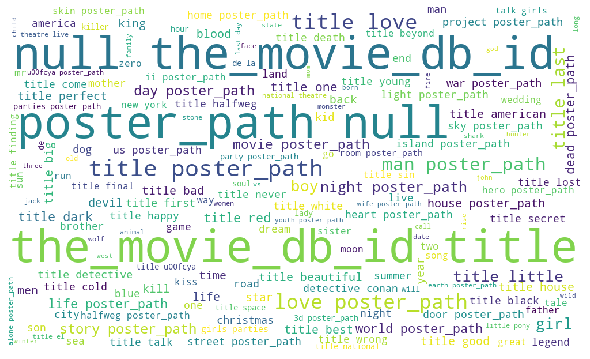

In [36]:
# importing all necessery modules for the word cloud

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# select 1000 titles and similar_movies from df pandas above
df = df_idf[["title", "similar_movies"]].head(1000)

top_words = " "
stopwords = set(STOPWORDS)

# iterate through this data set
for val in df["similar_movies"]:
   # typecaste each val to string
   val = str(val)

   # split the value
   tokens = val.split()

   # Converts each token into lowercase
   for i in range(len(tokens)):
       tokens[i] = tokens[i].lower()

   for words in tokens:
       top_words = top_words + words + " "


wordcloud = WordCloud(
    width=1000, 
    height=600,
    background_color="white",
    stopwords=stopwords,
    min_font_size=11,
).generate(top_words) # get top words

# plot the WordCloud image for title
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()